This file cotains the code for the model-based replication of the survey results.

In [1]:
!pip install transformers
!pip install sentence_transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=2c640427a6976b54d622aeb0f7ae6b31c6d7b4dddd21de6e5e47a75b2dcc200c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 3.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import json
import cv2
from tqdm.auto import tqdm
from accelerate import Accelerator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
#from transformers import AutoTokenizer, AutoModel

In [3]:
class Simple_Dataset(Dataset):

    ''' This class transforms the input data to a useable dataset, which can be passed
    to PyTorch's dataloader class in a very generic fashion. The collate function needs to
    actually define the variables here!'''

    def __init__(self, df):
        # also defining default value #

        # data as Pytorch tensors via the collate batches function
        self.data = np.array(df)

    def __getitem__(self, idx):
        return (self.data[idx])

    def __len__(self):
        return(self.data.shape[0])


In [4]:
# connecting to drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Reading in File with survey results per listing

In [5]:
# saving to drive

df_collapsed_results = pd.read_csv("/content/gdrive/My Drive/Thesis/survey_data/df_survey_collapsed_results.csv")

In [ ]:
df_collapsed_results.head(5)

,listing,llama_adapter,llama_adater_all,llama_no_peft,true_names
0,v_50_1,0.428571,0.285714,0.285714,0.000000
1,v_50_10,0.166667,0.333333,0.166667,0.333333
2,v_50_100,0.666667,0.000000,0.000000,0.333333
3,v_50_101,0.000000,0.166667,0.333333,0.500000
4,v_50_102,0.000000,0.000000,0.750000,0.250000


This DF needs to be casted to a long DF looking as follows:

In [6]:
df_new = pd.melt(df_collapsed_results, id_vars='listing', value_vars=['llama_adapter', 'llama_adater_all', 'llama_no_peft', 'true_names'])
df_new.head(10)

,listing,variable,value
0,v_50_1,llama_adapter,0.428571
1,v_50_10,llama_adapter,0.166667
2,v_50_100,llama_adapter,0.666667
3,v_50_101,llama_adapter,0.000000
4,v_50_102,llama_adapter,0.000000
5,v_50_103,llama_adapter,0.000000
6,v_50_104,llama_adapter,0.666667
7,v_50_105,llama_adapter,0.833333
8,v_50_106,llama_adapter,0.666667
9,v_50_107,llama_adapter,0.500000


Since this DF does not identify the listings, the metadata_X_txt files needed for the creation for the looping lists on Unipark need to be read in here and the id needs to be added to the DF.

In [7]:
metadata_1 = pd.read_csv("/content/gdrive/My Drive/Thesis/survey_data/metadata_3_1.txt", sep = ";")
metadata_2 = pd.read_csv("/content/gdrive/My Drive/Thesis/survey_data/metadata_3_2.txt", sep = ";")
metadata_3 = pd.read_csv("/content/gdrive/My Drive/Thesis/survey_data/metadata_3_3.txt", sep = ";")

metadata_listing_ids = pd.concat([metadata_1, metadata_2, metadata_3])

ids = [i.replace('survey_3_1_img_', '').replace('survey_3_2_img_', '').replace('survey_3_3_img_', '').replace('.png', '') for i in metadata_listing_ids.c3]

metadata_listing_ids['ids'] = ids

metadata_listing_ids.head(5)

,c1,c2,c3,c4,c5,c6,c7,c8,ids
0,1,1,survey_3_1_img_19443194.png,NaN,NaN,NaN,NaN,4,19443194
1,2,2,survey_3_1_img_23847732.png,NaN,NaN,NaN,NaN,4,23847732
2,3,3,survey_3_1_img_9531664.png,NaN,NaN,NaN,NaN,4,9531664
3,4,4,survey_3_1_img_13557685.png,NaN,NaN,NaN,NaN,4,13557685
4,5,5,survey_3_1_img_25000715.png,NaN,NaN,NaN,NaN,4,25000715


In [8]:
df_new['c2'] = [i.replace('v_50_', '').replace('v_51_', '').replace('v_52_', '') for i in df_new.listing]
df_new['c2'] = df_new['c2'].astype(int)

In [9]:
# merging ids and c2 (variable to aidentif by) to new df

df_new_ids = pd.merge(df_new, metadata_listing_ids[['c2', 'ids']], how = "left", on = "c2" )
df_new_ids.head()

,listing,variable,value,c2,ids
0,v_50_1,llama_adapter,0.428571,1,19443194
1,v_50_10,llama_adapter,0.166667,10,19956874
2,v_50_100,llama_adapter,0.666667,100,25973117
3,v_50_101,llama_adapter,0.000000,101,8069013
4,v_50_102,llama_adapter,0.000000,102,23955672


#### Setting up envirvonment for creating a Neural Net

* reading in jsons with embedded titles and description
* setting up colate batch function
* setting of an object for model training

Reading in already exisintg externally saved embeddiggs for names and descriptions.

In [10]:
with open("/content/gdrive/My Drive/Thesis/London_Data/json_names.json") as json_data:
    dict_names = json.load(json_data)

with open("/content/gdrive/My Drive/Thesis/London_Data/json_des.json") as json_data:
    dict_des = json.load(json_data)

with open("/content/gdrive/My Drive/Thesis/Discriminator_Predictions/json_llama_adapter_encoded_2.json") as json_data:
  dict_titles_llama_adapter_2 = json.load(json_data)

with open("/content/gdrive/My Drive/Thesis/Discriminator_Predictions/json_llama_no_peft_encoded_2.json") as json_data:
  dict_titles_llama_no_peft_2 = json.load(json_data)

Creating embedding for llama model which was trained on all listings.
Only needs to be executed when first running this notebook.

In [ ]:
#titles_all = pd.read_csv("/content/gdrive/My Drive/Thesis/loss_data/gen_titles_llama_adapter_v2_all.csv")
#dict_titles_llama_all = {}
#

In [ ]:
#model_save_name = 'sbert_tuned.pth'
#path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)

#text_model = torch.load(path)
#text_model = text_model.to("cuda")


In [ ]:
#for idx in range(titles_all.shape[0]):

#  print(idx/titles_all.shape[0])

#  id = titles_all.id[idx]

#  enc1 = text_model.encode(titles_all.gen_title[idx])
#  enc = enc1.tolist()

#  dict_titles_llama_all[int(id)] = enc

#  if idx % 200 == 0:
#    x = json.dumps(dict_titles_llama_all)
#    with open("/content/gdrive/My Drive/Thesis/Discriminator_Predictions/json_llama_all.json", 'w') as f:
#      f.write(x)

#x = json.dumps(dict_titles_llama_all)
#with open("/content/gdrive/My Drive/Thesis/Discriminator_Predictions/json_llama_all.json", 'w') as f:
#  f.write(x)



In [11]:
with open("/content/gdrive/My Drive/Thesis/Discriminator_Predictions/json_llama_all.json") as json_data:
  dict_titles_llama_all = json.load(json_data)

Creating collate batch function

In [12]:
def collate_batch(batch):

  list_name = []
  list_description = []
  list_ids = []
  list_value = [] # for the output
  list_type_name = [] # to have an idea on which type of title


  for data in batch:

    list_ids.append(data[4])

    list_value.append(data[2])

    list_description.append(dict_des[str(data[4])])

    if data[1] == "llama_adapter":
      list_name.append(dict_titles_llama_adapter_2[str(data[4])])
    elif data[1] == "llama_adater_all":
      list_name.append(dict_titles_llama_all[str(data[4])])
    elif data[1] == "llama_no_peft":
      list_name.append(dict_titles_llama_no_peft_2[str(data[4])])
    elif data[1] == "true_names":
      list_name.append(dict_names[str(data[4])])


    if data[1] == "llama_adapter":
      list_type_name.append('llama_adapter')
    elif data[1] == "llama_adater_all":
      list_type_name.append('llama_adater_all')
    elif data[1] == "llama_no_peft":
      list_type_name.append('llama_no_peft')
    elif data[1] == "true_names":
      list_type_name.append('true_names')


  # list ids to int
  list_ids = list(map(int, list_ids))

  list_name = torch.tensor(list_name  , dtype=torch.float32)
  list_description = torch.tensor(list_description  , dtype=torch.float32)
  list_ids = torch.tensor(list_ids  , dtype=torch.float32)
  list_value = torch.tensor(list_value  , dtype=torch.float32)

  return list_name, list_description, list_ids, list_value, list_type_name


In [ ]:
## train test split

df_new_ids_train = df_new_ids.sample(int(np.ceil(0.7*df_new_ids.shape[0])), random_state = 123 )
df_new_ids_eval  = df_new_ids.drop(df_new_ids_train.index, axis = 0)


In [34]:
# casting to "simpledataset"

data_train = Simple_Dataset(df_new_ids_train)
data_eval = Simple_Dataset(df_new_ids_eval)


In [35]:
# casting to dataloader

dl_train = DataLoader(data_train, collate_fn=collate_batch, batch_size=32, shuffle=True)
dl_eval = DataLoader(data_eval, collate_fn=collate_batch, batch_size=32, shuffle=True)


For the model design (below), an important consideration is whether to use an activation function like Sigmoid on the outputs of the final layer to bound to output by 0 and 1. In the problem at hand, these are the boundaries imposed on the attractiveness scores.

However, a sigmoid function struggles to output values very close to either zero or one as x ( in 1/(1+exp(-x)) would have to be either 0 (not as difficult) or extremely high (rather difficult). Hence, let's assess in how many cases 0 or 1 as the outcome scores are present in the data.

In [36]:

print(len(df_new_ids.value[df_new_ids.value == 0])/len(df_new_ids.value))

print(len(df_new_ids.value[df_new_ids.value == 1])/len(df_new_ids.value))




0.3862126245847176
0.024501661129568107


As in 38.6 percent of all data points, 0 zero is the associated outcome score, this would require an very high x value.

Thus, I decided to not use any bounding activation function before using the MSE loss.



In [16]:

import torch
from torch import nn
from torch import optim

final_output_dim_text_name = 40
final_output_dim_text_des = 40

hidden_dim_1 = 40
hidden_dim_2 = 40
hidden_dim_3 = 20
#hidden_dim_4 = 20

output_dim = 1


## name, des / text model


class NeuralNetwork2(nn.Module): ## without extractor
    def __init__(self , final_output_dim_text_name, final_output_dim_text_des, hidden_dim_1, hidden_dim_2, hidden_dim_3, output_dim):
        super(NeuralNetwork2, self).__init__()

        # Layers added after Name/Title
        self.name_added_layer_1 = nn.Linear(768, 100)
        self.name_added_layer_2 = nn.Linear(100, 100)
        ### dropout ##
        self.name_added_layer_3 = nn.Linear(100, final_output_dim_text_name)

        # Layers added after Description
        self.des_added_layer_1 = nn.Linear(768, 100)
        self.des_added_layer_2 = nn.Linear(100, 100)
        ### dropout ##
        self.des_added_layer_3 = nn.Linear(100, final_output_dim_text_des)


        ### Concatenation ###

        # dimension after concat operation
        self.concat_dim = final_output_dim_text_name + final_output_dim_text_des

        # layers processing input after concatination
        self.layer_1 = nn.Linear(self.concat_dim, hidden_dim_1)
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.layer_3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.layer_4 = nn.Linear(hidden_dim_3, output_dim)
#        self.layer_5 = nn.Linear(hidden_dim_4, output_dim)

        # Regu features
        self.dropout = nn.Dropout(0.03)
        self.batch_norm_1 = nn.BatchNorm1d(hidden_dim_2) # 1-dim batch norm with covariance-shift params activated
        self.batch_norm_2 = nn.BatchNorm1d(hidden_dim_3)


    def forward(self, name_encoded, des_encoded):


        # textual - description
        encoded_des = torch.tensor(des_encoded)
        encoded_des = torch.nn.functional.tanh(self.des_added_layer_1(encoded_des))
        encoded_des = self.dropout(encoded_des)
        encoded_des = torch.nn.functional.tanh(self.des_added_layer_2(encoded_des))
        encoded_des = self.dropout(encoded_des)
        final_encoded_des = torch.nn.functional.tanh(self.des_added_layer_3(encoded_des))

        # textual - Name
        encoded_name = torch.tensor(name_encoded)
        encoded_name = torch.nn.functional.tanh(self.name_added_layer_1(encoded_name))
        encoded_name = self.dropout(encoded_name)
        encoded_name = torch.nn.functional.tanh(self.name_added_layer_2(encoded_name))
        final_encoded_name = torch.nn.functional.tanh(self.name_added_layer_3(encoded_name))

        # concatination #
        x = torch.cat((final_encoded_name, final_encoded_des), 1)

        ## processing of joint representation ##    --- CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout
        x = torch.nn.functional.tanh(self.layer_1(x))
        x = self.layer_2(x)
        x = self.batch_norm_1(x)
        x = torch.nn.functional.tanh(self.dropout(x))
        x = self.layer_3(x)
        x = self.batch_norm_2(x)
        x = torch.nn.functional.tanh(self.dropout(x))
        x = self.layer_4(x)  # torch.nn.functional.tanh
#        x = self.layer_5(x)
#
        return x

### Model Training

In [ ]:
output_dim = 1 ## here

model = NeuralNetwork2(final_output_dim_text_name, final_output_dim_text_des, hidden_dim_1, hidden_dim_2, hidden_dim_3, output_dim)

learning_rate = 0.0025 ## found to be working well here
loss_fn = nn.MSELoss() ## BCE IN case of proxy
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) ## adam

In [ ]:
from transformers import get_scheduler

accelerator = Accelerator()
model, optimizer, dl_train, dl_eval = accelerator.prepare(
    model, optimizer, dl_train, dl_eval
)

num_update_steps_per_epoch = len(dl_train)
num_epochs = 35

num_training_steps = num_epochs * num_update_steps_per_epoch


lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,     ## one might also alter this!
    num_training_steps=num_training_steps,
)


device = "cuda"
model = model.to(device)

In [ ]:

overall_loss_values = []
overall_loss_values_eval = []


progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):

  loss_values = []
  loss_values_eval = []

  model.train()

  for batch in dl_train:

    name = torch.tensor(batch[0]).to(device)
    des = torch.tensor(batch[1]).to(device)
    Y = torch.tensor(batch[3]).to(device)
    optimizer.zero_grad()
    pred = model(name, des)
    loss = loss_fn(pred.squeeze(), Y)
    loss_values.append(loss.item())
    accelerator.backward(loss)

    optimizer.step()
    lr_scheduler.step()

    progress_bar.update(1)

  #  print(f"mean of train loss: {str(np.mean(loss_values))}")

  model.eval()

  with torch.no_grad():
    for batch in dl_eval:

      name = torch.tensor(batch[0]).to(device)
      des = torch.tensor(batch[1]).to(device)
      Y = torch.tensor(batch[3]).to(device)
      optimizer.zero_grad()
      pred = model(name, des)
      loss = loss_fn(pred.squeeze(), Y)
      loss_values_eval.append(loss.item())

    #  print(f"mean of eval loss: {str(np.mean(loss_values_eval))}")

  overall_loss_values.append(np.mean(loss_values))
  overall_loss_values_eval.append(np.mean(loss_values_eval))

#  print(f"Iteration No {str(epoch + 1)}")
#  print(f"Train Loss: {str(np.mean(loss_values))}")
#  print(f"Eval Loss: {str(np.mean(loss_values_eval))}")
#  print("---------------------")



  0%|          | 0/2415 [00:00<?, ?it/s]

<ipython-input-25-85ba026d8e24>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  name = torch.tensor(batch[0]).to(device)
<ipython-input-25-85ba026d8e24>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  des = torch.tensor(batch[1]).to(device)
<ipython-input-25-85ba026d8e24>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(batch[3]).to(device)
<ipython-input-16-36f38fe9f232>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_

In [ ]:
#saving the model
model_save_name = 'survey_replication_model.pth'

path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)
torch.save(model, path)

In [ ]:
print(f"The root-mse of the evaluation set is thus {np.sqrt(overall_loss_values_eval[-1])}.")
print(f"The root-mse of the train set is thus {np.sqrt(overall_loss_values[-1])}.")



The root-mse of the evaluation set is thus 0.1931776609383112.
The root-mse of the train set is thus 0.15837420100201596.


In [ ]:
print(f"The mse of the evaluation set is thus {overall_loss_values_eval[-1]}.")
print(f"The mse of the train set is thus {overall_loss_values[-1]}.")


The mse of the evaluation set is thus 0.038866445179218834.
The mse of the train set is thus 0.026957643191343632.


In [ ]:
print(f"The mse of the evaluation set is thus {overall_loss_values_eval[-1]}.")
print(f"The mse of the train set is thus {overall_loss_values[-1]}.")

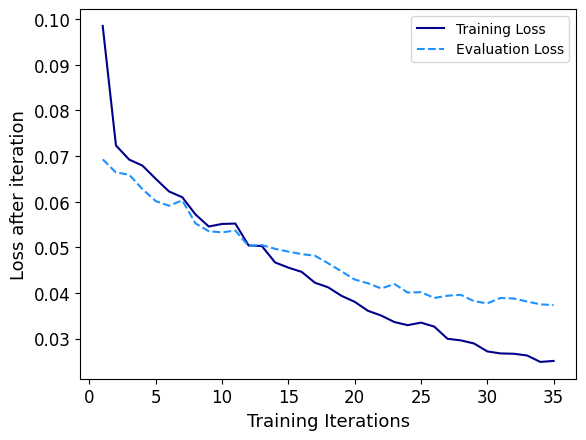

In [ ]:
# over  epochs
## plotting loss
import matplotlib.pyplot as plt
name_to_save = "losses_survey_replication_model"

epochs = list(range(1,num_epochs+1))

plt.plot(epochs, overall_loss_values, color = "darkblue")
plt.plot(epochs, overall_loss_values_eval, color = "dodgerblue", linestyle='dashed')
plt.legend(["Training Loss", "Evaluation Loss"], loc='upper right')
plt.xlabel("Training Iterations", fontsize=13)
plt.ylabel("Loss after iteration", fontsize=13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(f'/content/gdrive/My Drive/Thesis/Plots/{name_to_save}.png')
plt.show()

Analyzing results on a per-name type basis

In [37]:
# needed when calling the following in different session than model training

model_save_name = 'survey_replication_model.pth'
path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)


model = torch.load(path)


In [38]:
device = "cuda"
model = model.to(device)

In [39]:

ids = []
preds_ = []
name_types = []
Ys = []


model.eval()

with torch.no_grad():
  for batch in dl_eval:

    name = torch.tensor(batch[0]).to(device)
    des = torch.tensor(batch[1]).to(device)
    Y = torch.tensor(batch[3]).to(device)
    pred = model(name, des)

    ids.extend(batch[2].cpu().numpy() )
    preds_.extend(pred.cpu().numpy() )

    Ys.extend(Y.cpu().numpy() )
    name_types.extend(batch[4])

ids = [int(i) for i in ids]
preds = [a[0] for a in preds_ ]

<ipython-input-39-e7920fe44682>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  name = torch.tensor(batch[0]).to(device)
<ipython-input-39-e7920fe44682>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  des = torch.tensor(batch[1]).to(device)
<ipython-input-39-e7920fe44682>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(batch[3]).to(device)
<ipython-input-16-36f38fe9f232>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_

Lastly, let's see if this model truly predicts higher scores for titles wih associated higher attractiveness levels.


In [43]:
eval_data = pd.DataFrame({"id": ids, "pred": preds, 'Y':Ys, 'name_type': name_types})
eval_data.head()

,id,pred,Y,name_type
0,15753315,0.015160,0.000000,llama_adater_all
1,16200087,0.256929,0.000000,llama_adater_all
2,45751304,0.142075,0.666667,llama_adapter
3,17313748,0.604257,0.666667,llama_adapter
4,9154797,0.128339,0.000000,llama_adater_all


In [42]:
# correlation

np.corrcoef(eval_data.Y, eval_data.pred)

array([[1.        , 0.68770582],
       [0.68770582, 1.        ]])

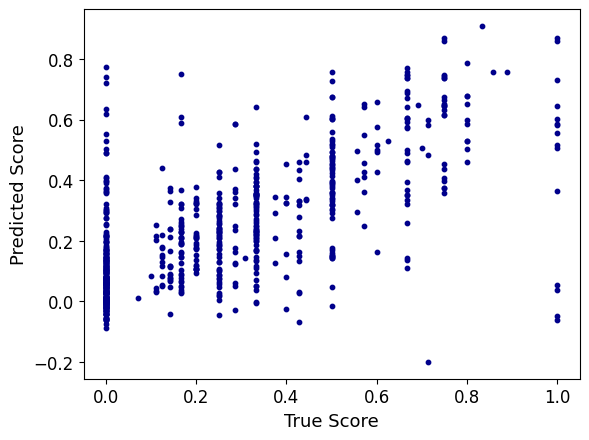

In [57]:
# plotting

name_to_save = "Sactter_survey_replication_model"

plt.scatter(eval_data.Y, eval_data.pred, color = "darkblue", s = 10)
plt.xlabel("True Score", fontsize=13)
plt.ylabel("Predicted Score", fontsize=13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(f'/content/gdrive/My Drive/Thesis/Plots/{name_to_save}.png')
plt.show()
